# **Homework #2_P2**

## **Problem 2: Semantic Segmentation** 
### **Task Definition**
In this assignment, you will need to perform semantic segmentation,
which predicts a label to each pixel with CNN models.     
• Input : RGB image     
• Output : Semantic Segmentation/Prediction

In this assignment, you will need to implement two segmentation
models and provide discussions in the report.
1. VGG16 + FCN32s (baseline model)
Implement VGG16-FCN32s model to perform segmentation.
The results of this model should pass the baseline performance.
2. An improved model
Implement an improved model to perform segmentation. The performance
of this model should be better than that of the baseline model. You may
choose any model different from VGG16-FCN32s, such as FCN16s, FCN8s,
U-Net, SegNet, etc.

### **Dataset**
• train/   
*   Contains 2000 image-mask (ground truth) pairs 
*   Satellite images are named 'xxxx_sat.jpg’
*   Mask images (ground truth) are named 'xxxx_mask.png'

• validation/   
*   Contains 257 image-mask pairs
*   Naming rules are the same as train/
*   You CANNOT use validation data for training purposes.

### **Implementation Details**
VGG16 Architecture

• You will need to load the pretrained weights of following layers:    
*Please use ImageNet pre-trained backbone.

### **Model Evaluation**

• Evaluation metric: mean Intersection over Union (mIoU)   
*   For each class, IoU is defined as:
    
    **True Positive / (True Positive + False Positive + False Negative)**    
*   mean IoU is calculated by averaging over all classes except Unknown(0,0,0).       
*   mIoU is calculated over all test images.

### **Grading - Problem 2: Semantic segmentation(70%)**

• Model Performance(40%)   
mIoU score should be above the baseline score to get points
*   On the validation set:
  *   Simple baseline (15%): 0.635
  *   Strong baseline (5%): 0.675
*   On the test set:
  *   Simple baseline (15%): 0.625
  *   Strong baseline (5%): 0.67

• TAs will execute your code to check if you pass the baseline.    
• Only TAs have the test data


In [ ]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
path = 'drive/My Drive/senior_1/DLCV/HW/hw2'

Mounted at /content/drive


In [ ]:
!gdown --id '1luNp4MCKzS85ay5rD5ke0HioGIQdkFJh' --output hw2_data.zip # 下載資料集
!unzip hw2_data.zip # 解壓縮N

In [ ]:
!pip3 install certifi==2020.6.20
!pip3 install cycler==0.10.0
!pip3 install joblib==0.17.0
!pip3 install kiwisolver==1.2.0
!pip3 install matplotlib==3.3.2
!pip3 install numpy==1.18.1
!pip3 install pandas==1.1.3
!pip3 install Pillow==8.0.0
!pip3 install pyparsing==2.4.7
!pip3 install python-dateutil==2.8.1
!pip3 install pytz==2020.1
!pip3 install scikit-learn==0.21.3
!pip3 install scipy==1.2.1
!pip3 install six==1.15.0
!pip3 install torch==1.4.0
!pip3 install torchvision==0.5.0

In [ ]:
# Import 需要的套件
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import random
import scipy.misc
import argparse
import imageio

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

In [ ]:
torchvision.__version__

'0.5.0'

#Read image

In [ ]:
def read_masks(filepath):
    '''
    Read masks from directory and tranform to categorical
    '''
    file_list = [file for file in os.listdir(filepath) if file.endswith('.png')] # label
    file_list.sort()
    n_masks = len(file_list)
    masks = np.empty((n_masks, 512, 512), dtype=np.uint8)

    for i, file in enumerate(file_list):
        # mask = scipy.misc.imread(os.path.join(filepath, file)) # TA
        mask = imageio.imread(os.path.join(filepath, file))
        mask = (mask >= 128).astype(int)
        mask = 4 * mask[:, :, 0] + 2 * mask[:, :, 1] + mask[:, :, 2]
        masks[i, mask == 3] = 0  # (Cyan: 011) Urban land 
        masks[i, mask == 6] = 1  # (Yellow: 110) Agriculture land 
        masks[i, mask == 5] = 2  # (Purple: 101) Rangeland 
        masks[i, mask == 2] = 3  # (Green: 010) Forest land 
        masks[i, mask == 1] = 4  # (Blue: 001) Water 
        masks[i, mask == 7] = 5  # (White: 111) Barren land 
        masks[i, mask == 0] = 6  # (Black: 000) Unknown
        masks[i, mask == 4] = 6  # (Red: 100) Unknown

    return masks

def mean_iou_score(pred, labels):
    '''
    Compute mean IoU score over 6 classes
    '''
    mean_iou = 0
    for i in range(6):
        tp_fp = np.sum(pred == i)
        tp_fn = np.sum(labels == i)
        tp = np.sum((pred == i) * (labels == i))
        iou = tp / (tp_fp + tp_fn - tp)
        mean_iou += iou / 6
        print('class #%d : %1.5f'%(i, iou))
    print('\nmean_iou: %f\n' % mean_iou)

    return mean_iou

In [ ]:
def readfile(path):
    image_dir = sorted(os.listdir(path)) # 把圖檔按照編號排列
    x = np.zeros((int(len(image_dir)/2), 512, 512, 3), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = imageio.imread(os.path.join(path, file))
        # print(file)
        if 'sat' in file:
            x[i//2, :, :] = img
    return x

In [ ]:
# 分別將 training set、validation set、testing set 用 readfile 函式讀進來
workspace_dir = './hw2_data'
print("Reading data")

train_x = readfile(os.path.join(workspace_dir, "p2_data/train"))                # [2000, 512, 512, 3] index: 0-255
print('finish train_x')
train_y = read_masks(os.path.join(workspace_dir, "p2_data/train"))              # [2000, 512, 512] index: 0-6
print('finish train_y')
print("Size of training data = {}".format(len(train_x)))

val_x = readfile(os.path.join(workspace_dir, "p2_data/validation"))             # [257, 512, 512, 3] index: 0-255
print('finish val_x')
val_y = read_masks(os.path.join(workspace_dir, "p2_data/validation"))           # [257, 512, 512] index: 0-6
print('finish val_y')
print("Size of validation data = {}".format(len(val_x)))

Reading data
finish train_x
finish train_y
Size of training data = 2000
finish val_x
finish val_y
Size of validation data = 257


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [ ]:
class ImgDataset(Dataset):
    def __init__(self, x, y): # transform 自己決定
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, index):
        X = self.x[index]
        Y = self.y[index]
        X = torch.LongTensor(X) # to long tensor
        Y = torch.LongTensor(Y) # to long tensor
        X = X.permute(2, 1, 0)
        Y = Y.permute(1, 0) # change
        
        return X, Y

In [ ]:
batch_size = 16
train_set = ImgDataset(train_x, train_y)
val_set = ImgDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Model

### improved model

In [ ]:
# improved model
class VGG16_FCN8s (nn.Module): 
    def __init__(self, original_model):
        super(VGG16_FCN8s, self).__init__()

        self.down_sampling_8 = nn.Sequential(           
            *list(original_model.features.children())[:17], # 最後是 [-1, 256, 64, 64] 
        )

        self.down_sampling_16 = nn.Sequential(         
            *list(original_model.features.children())[17:24], # 最後是 [-1, 512, 64, 64] 
        )

        self.down_sampling_32 = nn.Sequential(           
            *list(original_model.features.children())[24:], # 最後是 [-1, 512, 16, 16] 
        )


        self.fcn8 = nn.Sequential(        
            nn.Conv2d(256, 1024, kernel_size=(3, 3), padding = (1, 1)),  # [1024, 64, 64]
        )

        self.fcn16 = nn.Sequential(     
            nn.Conv2d(512, 1024, kernel_size=(3, 3), padding = (1, 1)),  # [1024, 32, 32]
        )

        self.fcn32 = nn.Sequential(           
            nn.Conv2d(512, 1024, kernel_size=(3, 3), padding = (1, 1)),  # [1024, 16, 16]
        )

        self.up_sampling_2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),   # [1024, 32, 32]     
        )

        self.up_sampling_4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),   # [1024, 64, 64]     
        )

        self.up_sampling_8 = nn.Sequential(
            nn.Conv2d(1024, 4096, kernel_size=(3, 3), padding = (1, 1)),  # [4096, 16, 16]
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(4096, 1024, kernel_size=(1, 1)),  # [1024, 16, 16]
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(1024, 7, kernel_size=(1, 1)),  # [7, 16, 16] 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(7, 7, kernel_size=(32, 32), stride=(8, 8), padding=(12, 12)),   # [7, 512, 512]     
        )

    def forward(self, x):
      
        out = self.down_sampling_8(x)       # [-1, 256, 64, 64] 
        out8 = out
        out = self.down_sampling_16(out)    # [-1, 512, 32, 32]    
        out16 = out
        out = self.down_sampling_32(out)    # [-1, 512, 16, 16]
        out32 = out

        out32 = self.fcn32(out32)           # [-1, 1024, 16, 16]
        out32 = self.up_sampling_2(out32)   # [-1, 1024, 32, 32]
        out16 = self.fcn16(out16)           # [-1, 1024, 32, 32]
        out16 = out32 + out16               # [-1, 1024, 32, 32] + [-1, 1024, 32, 32]

        out16 = self.up_sampling_4(out16)   # [-1, 1024, 64, 64]
        out8 = self.fcn8(out8)              # [-1, 1024, 64, 64]
        out8 = out16 + out8                 # [-1, 1024, 64, 64] + [-1, 1024, 64, 64]

        upscore = self.up_sampling_8(out8)  # [-1, 7, 512, 512]

        return upscore

In [ ]:
# model = models.vgg16(pretrained=True)
# improved_model =  VGG16_FCN8s(model).cuda()

# from torchsummary import summary
# summary(improved_model, input_size=(3, 512, 512))

# Training

使用 training set 訓練，並使用 validation set 尋找好的參數

In [ ]:
loss = nn.CrossEntropyLoss() 
model = models.vgg16(pretrained=True)
improved_model =  VGG16_FCN8s(model).cuda()
optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.0001) # optimizer 使用 Adam
num_epoch = 30
best_mean_iou = 0
print('start training')

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_mean_iou = 0.0
    train_loss = 0.0
    val_mean_iou = 0.0
    val_loss = 0.0

    improved_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader): # 裡面要 long，iterate 2000/batch_size
        inputs = data[0].cuda() 
        labels = data[1].cuda()
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = improved_model(inputs.float().squeeze()) # [batch_size, 7, 512, 512]
        batch_loss = loss(train_pred, labels.squeeze()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上
        print(i, 'batch loss =', batch_loss.item())
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值
        train_loss += batch_loss.item()

    print('train loss =', train_loss)
    print('finish training', epoch)
    
    improved_model.eval()
    initial = False

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs = data[0].cuda()
            labels = data[1].cuda()
            val_pred = improved_model(inputs.float().squeeze(1))
            if initial == False:
                pred_array = torch.argmax(val_pred, dim=1).cpu().data.numpy()
                labels_array = labels.squeeze(1).cpu().data.numpy()
                initial = True
            else:
                pred_array = np.concatenate((pred_array, torch.argmax(val_pred, dim=1).cpu().data.numpy()), axis=0)
                labels_array = np.concatenate((labels_array, labels.squeeze(1).cpu().data.numpy()), axis=0)
            batch_loss = loss(val_pred, labels.squeeze(1))
            print(i, 'batch loss =', batch_loss.item())
            val_loss += batch_loss.item()
        
        print('val loss =', val_loss)
        val_mean_iou = mean_iou_score(pred_array, labels_array)
        if(val_mean_iou > best_mean_iou):
            best_mean_iou = val_mean_iou
            torch.save(improved_model.state_dict(), path + '/new_improved_model_best_p2.pkl')
            print('save improved_model_best_p2')

        # if epoch == 0:
        #     torch.save(improved_model.state_dict(), path + '/improved_model_early_p2.pkl')
        #     print('save improved_model_early_p2')

        # elif epoch == 15:
        #     torch.save(improved_model.state_dict(), path + '/improved_model_middle_p2.pkl')
        #     print('save improved_model_middle_p2')

        # elif epoch == num_epoch-1:
        #     torch.save(improved_model.state_dict(), path + '/improved_model_final_p2.pkl')
        #     print('save improved_model_final_p2')

        print('finish valdiation', epoch)

        #將結果 print 出來
        print('best_mean_iou =', best_mean_iou) 
        print('training time =',  time.time() - epoch_start_time)

In [ ]:
# fine tune
import time
loss = nn.CrossEntropyLoss() 
model = models.vgg16(pretrained=True)
improved_model =  VGG16_FCN8s(model).cuda()
improved_model.load_state_dict(torch.load(path + '/summit_new_improved_model_best_p2.pkl'))
optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.00001) # optimizer 使用 Adam
num_epoch = 15
print('start training')

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_mean_iou = 0.0
    train_loss = 0.0
    val_mean_iou = 0.0
    val_loss = 0.0

    improved_model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader): # 裡面要 long，iterate 2000/batch_size
        inputs = data[0].cuda() 
        labels = data[1].cuda()
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = improved_model(inputs.float().squeeze()) # [batch_size, 7, 512, 512]
        batch_loss = loss(train_pred, labels.squeeze()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上
        print(i, 'batch loss =', batch_loss.item())
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值
        train_loss += batch_loss.item()

    print('train loss =', train_loss)
    print('finish training', epoch)
    
    improved_model.eval()
    initial = False

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs = data[0].cuda()
            labels = data[1].cuda()
            val_pred = improved_model(inputs.float().squeeze(1))
            if initial == False:
                pred_array = torch.argmax(val_pred, dim=1).cpu().data.numpy()
                labels_array = labels.squeeze(1).cpu().data.numpy()
                initial = True
            else:
                pred_array = np.concatenate((pred_array, torch.argmax(val_pred, dim=1).cpu().data.numpy()), axis=0)
                labels_array = np.concatenate((labels_array, labels.squeeze(1).cpu().data.numpy()), axis=0)
            batch_loss = loss(val_pred, labels.squeeze(1))
            print(i, 'batch loss =', batch_loss.item())
            val_loss += batch_loss.item()
        
        print('val loss =', val_loss)
        val_mean_iou = mean_iou_score(pred_array, labels_array)
        torch.save(improved_model.state_dict(), path + '/' + str(val_mean_iou) + '_new_improved_model_best_p2.pkl')
        print('save improved_model_best_p2')

        print('finish valdiation', epoch)

        #將結果 print 出來
        print('training time =',  time.time() - epoch_start_time)

#test

In [ ]:
import time
model = models.vgg16(pretrained=True)
improved_model =  VGG16_FCN8s(model).cuda()
improved_model.load_state_dict(torch.load(path + '/summit_new_improved_model_best_p2.pkl'))
improved_model.eval()
initial = False

with torch.no_grad():
    val_loss = 0.0
    loss = nn.CrossEntropyLoss() 
    epoch_start_time = time.time()
    for i, data in enumerate(val_loader):
        inputs = data[0].cuda()
        labels = data[1].cuda()
        val_pred = improved_model(inputs.float().squeeze(1))
        if initial == False:
            pred_array = torch.argmax(val_pred, dim=1).cpu().data.numpy()
            labels_array = labels.squeeze(1).cpu().data.numpy()
            initial = True
        else:
            pred_array = np.concatenate((pred_array, torch.argmax(val_pred, dim=1).cpu().data.numpy()), axis=0)
            labels_array = np.concatenate((labels_array, labels.squeeze(1).cpu().data.numpy()), axis=0)
        batch_loss = loss(val_pred, labels.squeeze(1))
        print(i, 'batch loss =', batch_loss.item())
        val_loss += batch_loss.item()
        
    print('val loss =', val_loss)
    val_mean_iou = mean_iou_score(pred_array, labels_array)
    print('finish valdiation test')

    #將結果 print 出來
    print('validation time =',  time.time() - epoch_start_time)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



0 batch loss = 0.5962430238723755
1 batch loss = 0.7450567483901978
2 batch loss = 0.735892117023468
3 batch loss = 0.6839780211448669
4 batch loss = 0.779864490032196
5 batch loss = 0.7831605672836304
6 batch loss = 0.641805112361908
7 batch loss = 0.5177710056304932
8 batch loss = 0.5566954016685486
9 batch loss = 0.8021054863929749
10 batch loss = 0.6344878077507019
11 batch loss = 0.5979242920875549
12 batch loss = 0.8780899047851562
13 batch loss = 0.5176706314086914
14 batch loss = 0.4425659775733948
15 batch loss = 0.9874058365821838
16 batch loss = 0.06137962266802788
val loss = 10.96209604665637
class #0 : 0.74765
class #1 : 0.87178
class #2 : 0.28363
class #3 : 0.79312
class #4 : 0.74175
class #5 : 0.61376

mean_iou: 0.675282

finish valdiation test
validation time = 48.01968431472778


#Report

• Report(30%)
1. (5%) Print the network architecture of your VGG16-FCN32s model.

2. (5%) Show the predicted segmentation mask of “validation/0010_sat.jpg”, “validation/0097_sat.jpg”,
“validation/0107_sat.jpg” during the early, middle, and the final stage during the training stage. (For
example, results of 1st, 10th, 20th epoch)

3. (5%) Implement an improved model which performs better than your baseline model. Print the network
architecture of this model.

In [ ]:
print(improved_model)

VGG16_FCN8s(
  (down_sampling_8): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

4. (5%) Show the predicted segmentation mask of “validation/0010_sat.jpg”, “validation/0097_sat.jpg”,
“validation/0107_sat.jpg” during the early, middle, and the final stage during the training process of this
improved model.

In [ ]:
def change_color_masks(seg):
    masks = np.zeros((512, 512, 3))
    masks[seg == 0] = [0, 255, 255]  # (Cyan: 011) Urban land 
    masks[seg == 1] = [255, 255, 0]  # (Yellow: 110) Agriculture land 
    masks[seg == 2] = [255, 0, 255]  # (Purple: 101) Rangeland 
    masks[seg == 3] = [0, 255, 0]  # (Green: 010) Forest land 
    masks[seg == 4] = [0, 0, 255]  # (Blue: 001) Water 
    masks[seg == 5] = [255, 255, 255]  # (White: 111) Barren land 
    masks[seg == 6] = [0, 0, 0]  # (Black: 000) Unknown
    return masks

In [ ]:
from PIL import Image
import matplotlib

mask_file = []
mask_file.append(val_x[10])
mask_file.append(change_color_masks(val_y[10]))
mask_file.append(val_x[97])
mask_file.append(change_color_masks(val_y[97]))
mask_file.append(val_x[107])
mask_file.append(change_color_masks(val_y[107]))

for model_type in ['back_up_model/improved_model_early_p2.pkl', 'back_up_model/improved_model_middle_p2.pkl', 'back_up_model/improved_model_final_p2.pkl']:
    model = models.vgg16(pretrained=True)
    improved_model =  VGG16_FCN8s(model).cuda()
    improved_model.load_state_dict(torch.load(os.path.join(path, model_type)))
    improved_model.eval()
    initial = False

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            if i > 7:
                break
            else:
                inputs = data[0].cuda()
                labels = data[1].cuda()
                val_pred = improved_model(inputs.float().squeeze(1))           
                if initial == False:
                    pred_array = torch.argmax(val_pred, dim=1).cpu().data.numpy()
                    labels_array = labels.squeeze(1).cpu().data.numpy()
                    initial = True
                else:
                    pred_array = np.concatenate((pred_array, torch.argmax(val_pred, dim=1).cpu().data.numpy()), axis=0)
                    labels_array = np.concatenate((labels_array, labels.squeeze(1).cpu().data.numpy()), axis=0)


    mask_file.append(change_color_masks(torch.LongTensor(pred_array[10]).permute(1, 0).numpy()))
    mask_file.append(change_color_masks(torch.LongTensor(pred_array[97]).permute(1, 0).numpy()))
    mask_file.append(change_color_masks(torch.LongTensor(pred_array[107]).permute(1, 0).numpy()))

        #將結果 print 出來
    print('finish' + ' ' + model_type)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



finish back_up_model/improved_model_early_p2.pkl
finish back_up_model/improved_model_middle_p2.pkl
finish back_up_model/improved_model_final_p2.pkl


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

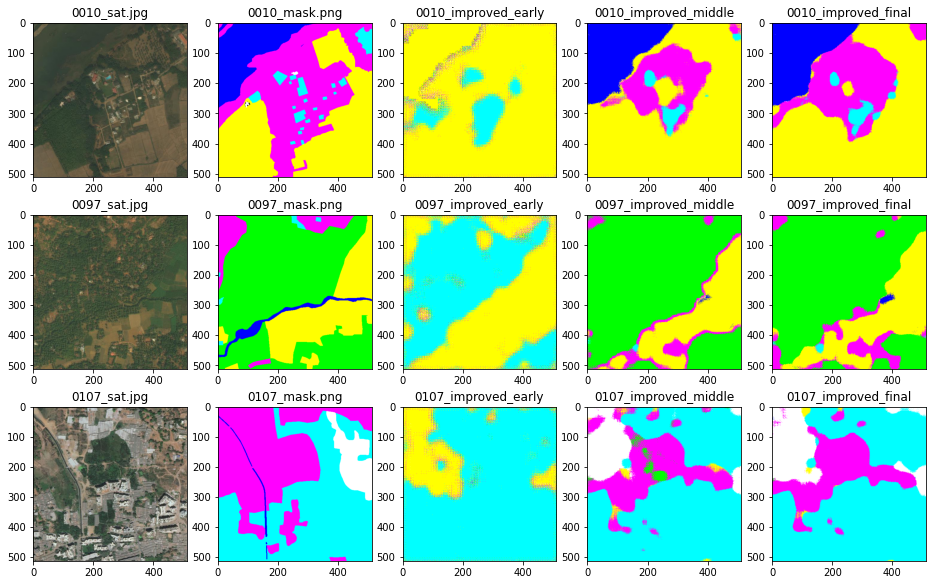

In [ ]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

plt.figure(figsize=(16, 10))
plt.subplot(3, 5, 1)
plt.title('0010_sat.jpg')
plt.imshow(mask_file[0])
plt.subplot(3, 5, 6)
plt.title('0097_sat.jpg')
plt.imshow(mask_file[2])
plt.subplot(3, 5, 11)
plt.title('0107_sat.jpg')
plt.imshow(mask_file[4])

plt.subplot(3, 5, 2)
plt.title('0010_mask.png')
plt.imshow(mask_file[1])
plt.subplot(3, 5, 7)
plt.title('0097_mask.png')
plt.imshow(mask_file[3])
plt.subplot(3, 5, 12)
plt.title('0107_mask.png')
plt.imshow(mask_file[5])

plt.subplot(3, 5, 3)
plt.title('0010_improved_early')
plt.imshow(mask_file[6])
plt.subplot(3, 5, 8)
plt.title('0097_improved_early')
plt.imshow(mask_file[7])
plt.subplot(3, 5, 13)
plt.title('0107_improved_early')
plt.imshow(mask_file[8])

plt.subplot(3, 5, 4)
plt.title('0010_improved_middle')
plt.imshow(mask_file[9])
plt.subplot(3, 5, 9)
plt.title('0097_improved_middle')
plt.imshow(mask_file[10])
plt.subplot(3, 5, 14)
plt.title('0107_improved_middle')
plt.imshow(mask_file[11])

plt.subplot(3, 5, 5)
plt.title('0010_improved_final')
plt.imshow(mask_file[12])
plt.subplot(3, 5, 10)
plt.title('0097_improved_final')
plt.imshow(mask_file[13])
plt.subplot(3, 5, 15)
plt.title('0107_improved_final')
plt.imshow(mask_file[14])

plt.show()

5. (10%) Report mIoU score of both models on the validation set. Discuss the reason why the improved
model performs better than the baseline one. You may conduct some experiments and show some
evidences to support your reasoning.

In [ ]:
def change_color_masks(seg):
    masks = np.zeros((512, 512, 3))
    masks[seg == 0] = [0, 255, 255]  # (Cyan: 011) Urban land 
    masks[seg == 1] = [255, 255, 0]  # (Yellow: 110) Agriculture land 
    masks[seg == 2] = [255, 0, 255]  # (Purple: 101) Rangeland 
    masks[seg == 3] = [0, 255, 0]  # (Green: 010) Forest land 
    masks[seg == 4] = [0, 0, 255]  # (Blue: 001) Water 
    masks[seg == 5] = [255, 255, 255]  # (White: 111) Barren land 
    masks[seg == 6] = [0, 0, 0]  # (Black: 000) Unknown
    return masks

In [ ]:
# baseline model
class VGG16_FCN32s (nn.Module): 
    def __init__(self, original_model):
        super(VGG16_FCN32s, self).__init__()
        self.down_sampling = nn.Sequential(
            
            *list(original_model.features.children())[:], # 最後是 [-1, 512, 16, 16] 

        )

        self.fcn = nn.Sequential(
            
            nn.Conv2d(512, 4096, kernel_size=(3, 3), padding = (1, 1)),  # [4096, 16, 16]
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.7),
            nn.Conv2d(4096, 4096, kernel_size=(1, 1)),  # [4096, 16, 16]
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.7),
            nn.Conv2d(4096, 7, kernel_size=(1, 1)),  # [7, 16, 16] 
            nn.ReLU(inplace=True),

        )

        self.up_sampling = nn.Sequential(
            
            # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
            nn.ConvTranspose2d(7, 7, kernel_size=(64, 64), stride=(32, 32), padding=(16, 16)),   # [7, 512, 512]     
        )

    def forward(self, x):

        out = self.down_sampling(x)
        out = self.fcn(out)
        upscore = self.up_sampling(out) # [batch_size, 7, 512, 512]

        return upscore 

In [ ]:
from PIL import Image
import matplotlib

mask_file = []
mask_file.append(val_x[6])
mask_file.append(change_color_masks(val_y[6]))
mask_file.append(val_x[13])
mask_file.append(change_color_masks(val_y[13]))
mask_file.append(val_x[120])
mask_file.append(change_color_masks(val_y[120]))

for model_type in ['summit_new_improved_model_best_p2.pkl', 'summit_new_baseline_model_best_p2.pkl']:
    model = models.vgg16(pretrained=True)
    if model_type == 'summit_new_improved_model_best_p2.pkl':
        chosen_model =  VGG16_FCN8s(model).cuda()
        chosen_model.load_state_dict(torch.load(os.path.join(path, model_type)))
    else:
        chosen_model =  VGG16_FCN32s(model).cuda()
        chosen_model.load_state_dict(torch.load(os.path.join(path, model_type)))
    chosen_model.eval()
    initial = False

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            if i > 7:
                break
            else:
                inputs = data[0].cuda()
                labels = data[1].cuda()
                val_pred = chosen_model(inputs.float().squeeze(1))           
                if initial == False:
                    pred_array = torch.argmax(val_pred, dim=1).cpu().data.numpy()
                    labels_array = labels.squeeze(1).cpu().data.numpy()
                    initial = True
                else:
                    pred_array = np.concatenate((pred_array, torch.argmax(val_pred, dim=1).cpu().data.numpy()), axis=0)
                    labels_array = np.concatenate((labels_array, labels.squeeze(1).cpu().data.numpy()), axis=0)


    mask_file.append(change_color_masks(torch.LongTensor(pred_array[6]).permute(1, 0).numpy()))
    mask_file.append(change_color_masks(torch.LongTensor(pred_array[13]).permute(1, 0).numpy()))
    mask_file.append(change_color_masks(torch.LongTensor(pred_array[120]).permute(1, 0).numpy()))

        #將結果 print 出來
    print('finish' + ' ' + model_type)

finish summit_new_improved_model_best_p2.pkl
finish summit_new_baseline_model_best_p2.pkl


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


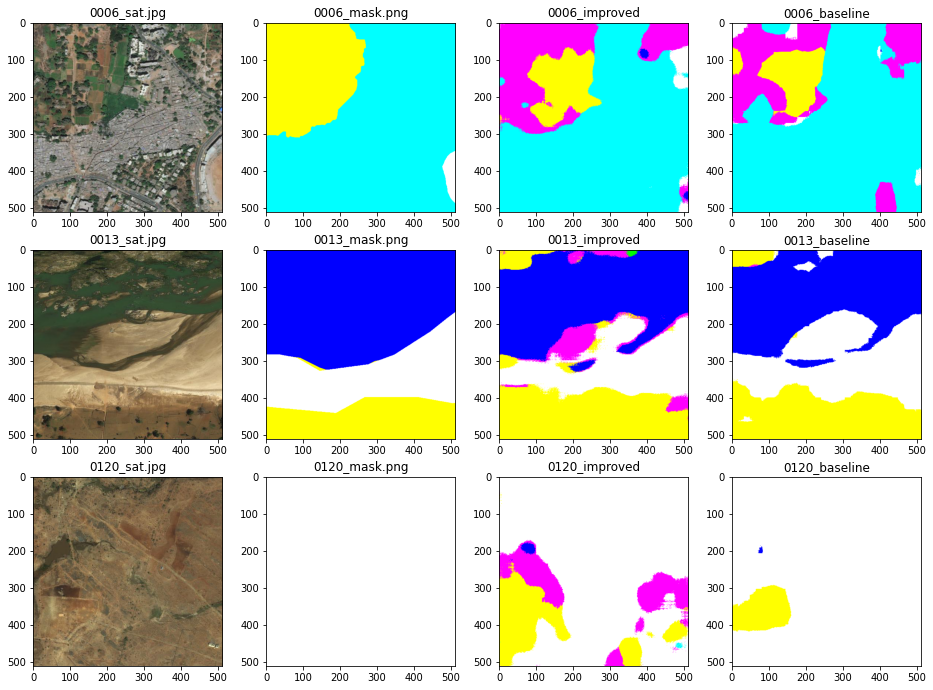

In [ ]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

plt.figure(figsize=(16, 16))
plt.subplot(4, 4, 1)
plt.title('0006_sat.jpg')
plt.imshow(mask_file[0])
plt.subplot(4, 4, 5)
plt.title('0013_sat.jpg')
plt.imshow(mask_file[2])
plt.subplot(4, 4, 9)
plt.title('0120_sat.jpg')
plt.imshow(mask_file[4])

plt.subplot(4, 4, 2)
plt.title('0006_mask.png')
plt.imshow(mask_file[1])
plt.subplot(4, 4, 6)
plt.title('0013_mask.png')
plt.imshow(mask_file[3])
plt.subplot(4, 4, 10)
plt.title('0120_mask.png')
plt.imshow(mask_file[5])

plt.subplot(4, 4, 3)
plt.title('0006_improved')
plt.imshow(mask_file[6])
plt.subplot(4, 4, 7)
plt.title('0013_improved')
plt.imshow(mask_file[7])
plt.subplot(4, 4, 11)
plt.title('0120_improved')
plt.imshow(mask_file[8])

plt.subplot(4, 4, 4)
plt.title('0006_baseline')
plt.imshow(mask_file[9])
plt.subplot(4, 4, 8)
plt.title('0013_baseline')
plt.imshow(mask_file[10])
plt.subplot(4, 4, 12)
plt.title('0120_baseline')
plt.imshow(mask_file[11])

plt.show()